In [189]:
from cirq_sic import *
import recirq

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default") 

from IPython.display import display, Math, Markdown

# Metrics as a function of n_shots

In [5]:
experiment_name = "sky_ground"
base_dir = f'../experiments/data/{experiment_name}'

query = {"dataset_id": "9_18_25",
         "processor_id": "willow_pink",
         "d": 4}
records = recirq.load_records(dataset_id=query["dataset_id"], base_dir=base_dir)
n_shots_list = [1000, 5000, 10000, 20000, 50000, 100000]

all_metrics = {}
for run_type in ["clean", "noisy"]:
    for wh_implementation in ["simple", "ak"]:
      results = dict([(program.description,\
                       query_records(records, {**query, "description": program.description,\
                                                        "run_type": run_type,\
                                                        "wh_implementation": wh_implementation}))\
                        for program in sky_ground_programs])
      all_metrics[(run_type, wh_implementation)] = results_to_sky_ground_metrics(results)

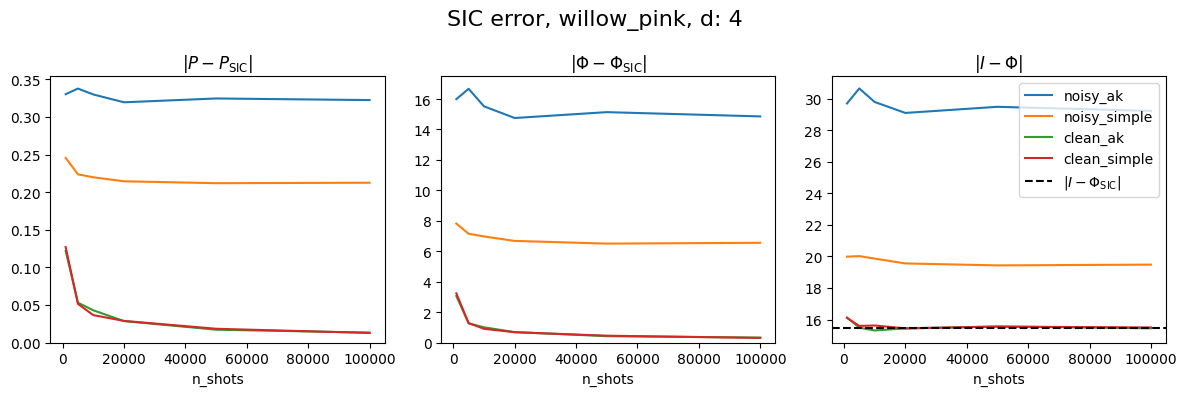

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

keys = [("noisy", "ak"),("noisy", "simple"), ("clean", "ak"), ("clean", "simple")]
for key in keys:
    metrics = all_metrics[key]
    axes[0].plot(n_shots_list, [metrics[n_shots]["P_err"] for n_shots in n_shots_list], label="_".join(key))
    axes[1].plot(n_shots_list, [metrics[n_shots]["Phi_err"] for n_shots in n_shots_list], label="_".join(key))
    axes[2].plot(n_shots_list, [metrics[n_shots]["quantumness"] for n_shots in n_shots_list], label="_".join(key))

axes[0].set_title(r"$|P - P_{\text{SIC}}|$")
axes[0].set_ylim(bottom=0)
axes[0].set_xlabel("n_shots")

axes[1].set_title(r"$|\Phi - \Phi_{\text{SIC}}|$")
axes[1].set_ylim(bottom=0)
axes[1].set_xlabel("n_shots")

axes[2].set_title(r"$|I - \Phi|$")
axes[2].axhline(np.linalg.norm(np.eye(query["d"]**2) - np.linalg.inv(SIC_P(query["d"]))), color='black', linestyle='--', label=r"$|I - \Phi_{\text{SIC}}|$")
axes[2].set_xlabel("n_shots")
axes[2].legend()

fig.suptitle("SIC error, %s, d: %d" %  (query["processor_id"],  query["d"]), fontsize=16)
plt.tight_layout()
fig.savefig("img/sic_metrics.pdf", bbox_inches='tight')
plt.show()

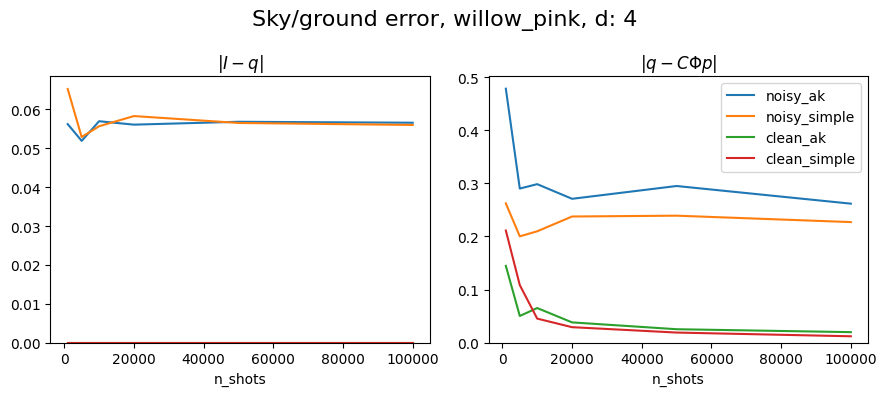

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

keys = [("noisy", "ak"),("noisy", "simple"), ("clean", "ak"), ("clean", "simple")]
for key in keys:
    metrics = all_metrics[key]
    axes[0].plot(n_shots_list, [metrics[n_shots]["q_err"] for n_shots in n_shots_list], label="_".join(key))
    axes[1].plot(n_shots_list, [metrics[n_shots]["sg_q_err"] for n_shots in n_shots_list], label="_".join(key))

axes[0].set_title(r"$|I - q|$")
axes[0].set_xlabel("n_shots")
axes[0].set_ylim(bottom=0)

axes[1].set_title(r"$|q - C \Phi p|$")
axes[1].set_xlabel("n_shots")
axes[1].set_ylim(bottom=0)
axes[1].legend()

fig.suptitle("Sky/ground error, %s, d: %d" %  (query["processor_id"],  query["d"]), fontsize=16)
plt.tight_layout()
fig.savefig("img/sg_metrics.pdf", bbox_inches='tight')
plt.show()

### Drilling down

In [120]:
experiment_name = "sky_ground"
base_dir = f'../experiments/data/{experiment_name}'

query = {"dataset_id": "9_18_25",
         "processor_id": "willow_pink",
         "run_type": "noisy",
         "wh_implementation": "ak",
         "n_shots": 100000,
         "d": 4}
records = recirq.load_records(dataset_id=query["dataset_id"], base_dir=base_dir)
results = dict([(program.description,\
                query_records(records, {**query, "description": program.description}))\
                      for program in sky_ground_programs])

In [121]:
P = np.array(results["characterize_wh_reference_device"][0]["P"])
p = np.array(results["wh_povm_on_basis_states"][0]["p"])
C = np.array(results["basis_measurement_on_wh_states"][0]["C"])
q = np.array(results["basis_measurement_on_basis_states"][0]["q"])

# Fix this at a more fundamental level.
if query["wh_implementation"] == "ak":
    P = change_conjugate_convention(P)
    C = change_conjugate_convention(C)

Phi = np.linalg.inv(P)
q_ = C @ Phi @ p
context_str = "%s, run_type: %s, wh_impl: %s, n_shots: %d, d: %d" % \
                    (query["processor_id"], query["run_type"], query["wh_implementation"], query["n_shots"], query["d"])
globals().update(calculate_sky_ground_metrics(P, p, C, q, verbose=True))

Sky/Ground Metrics:
||P - P_SIC|| = 0.322455471964735
|Phi - Phi_SIC| = 14.857807647244424
|I - Phi| = 29.223480844572613
|I - Phi_SIC| = 15.491933384829668
|I - q| = 0.05658932761572622
|q - C Phi p| = 0.2618490662650019


## $P$ vs $P_{\text{SIC}}$

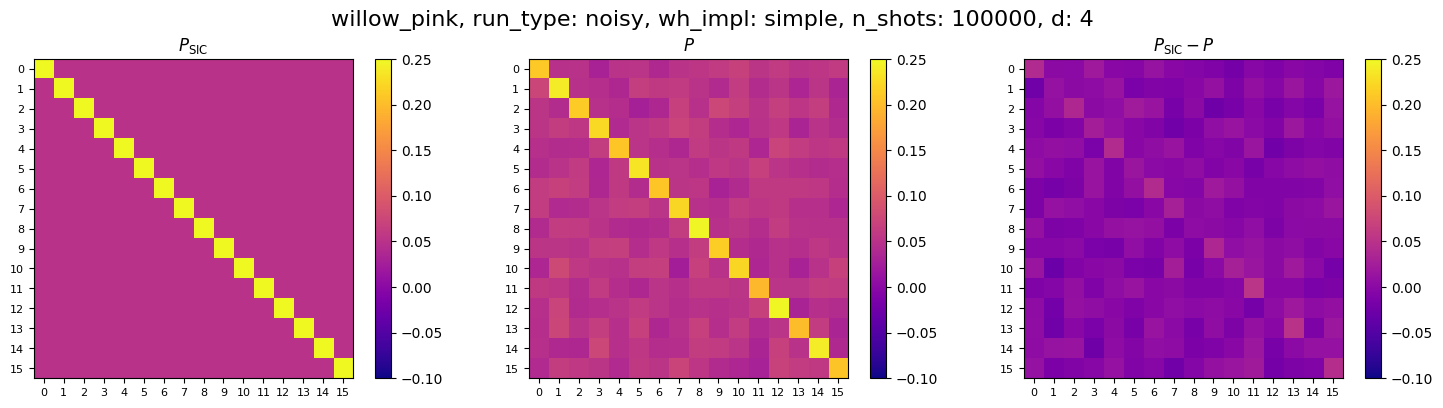

In [116]:
P_sic = SIC_P(query["d"])
n = query["d"]**2
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, mat, title in zip(axes, [P_sic, P, P_sic-P], [r'$P_{\text{SIC}}$', r'$P$', r'$P_{\text{SIC}}-P$']):
    im = ax.imshow(mat, cmap='plasma', extent=[-0.5, n-1/2, n-1/2, -0.5], vmin=-0.1, vmax=1/4)
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels([str(i) for i in range(n)], fontsize=8)
    ax.set_yticklabels([str(i) for i in range(n)], fontsize=8)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, label='')
fig.suptitle(context_str, fontsize=16)
plt.tight_layout()
fig.savefig("img/P_%s_%s_%d.pdf" % (query["run_type"], query["wh_implementation"], query["n_shots"]), bbox_inches='tight')
plt.show()

## $q$ vs $C\Phi p$

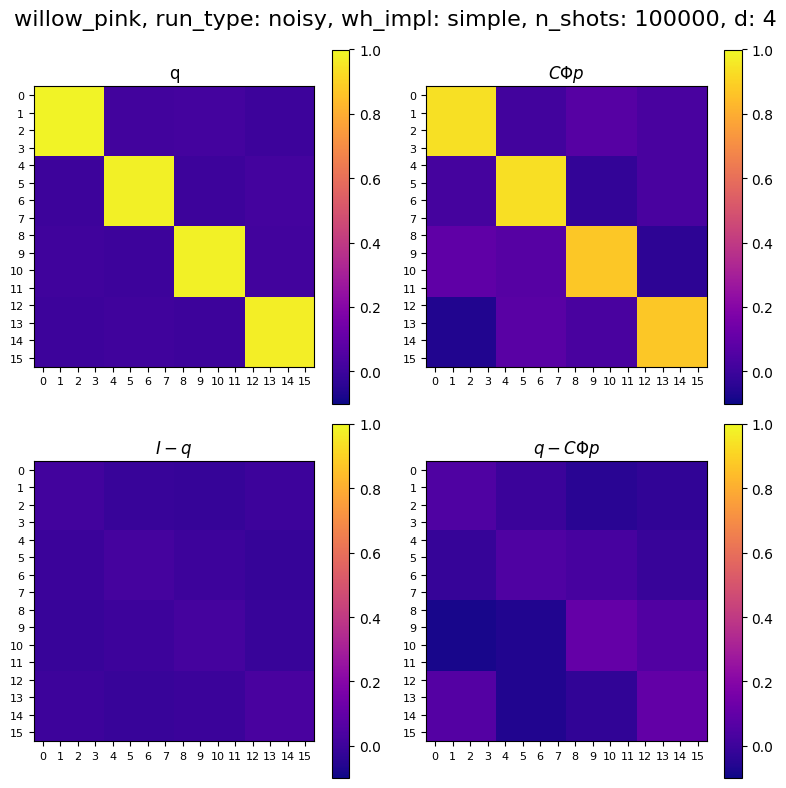

In [117]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
n = query["d"]**2
for ax, mat, title in zip(axes, [q, q_, np.eye(query["d"]) - q, q - q_], ['q', r'$C\Phi p$', r"$I-q$", r'$q - C\Phi p$']):
    im = ax.imshow(mat, cmap='plasma', extent=[-0.5, n-1/2, n-1/2, -0.5],  vmin=-0.1, vmax=1)
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels([str(i) for i in range(n)], fontsize=8)
    ax.set_yticklabels([str(i) for i in range(n)], fontsize=8)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, label='')
fig.suptitle(context_str, fontsize=16)
plt.tight_layout()
fig.savefig("img/q_%s_%s_%d.pdf" % (query["run_type"], query["wh_implementation"], query["n_shots"]), bbox_inches='tight')
plt.show()